In [5]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid


In [6]:
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

In [7]:
dir0=r"C:\Users\Aalind\Desktop\Driver Drowsiness Dataset (DDD)"

In [8]:
classes=[]
paths=[]
for dirname, _, filenames in os.walk(dir0):
    for filename in filenames:
        if not filename.endswith('.txt'):
            classes+=[dirname.split('/')[-1]]
            paths+=[(os.path.join(dirname, filename))]

In [9]:
N=list(range(len(classes)))
class_names=sorted(set(classes))
print(class_names)
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))       

data=pd.DataFrame(columns=['path','class','label'])
data['path']=paths
data['class']=classes
data['label']=data['class'].map(normal_mapping)
print(len(data))

['C:\\Users\\Aalind\\Desktop\\Driver Drowsiness Dataset (DDD)\\Drowsy', 'C:\\Users\\Aalind\\Desktop\\Driver Drowsiness Dataset (DDD)\\Non Drowsy']
41793


In [10]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [11]:
def create_path_label_list(df):
    path_label_list = []
    for _, row in df.iterrows():
        path = row['path']
        label = row['label']
        path_label_list.append((path, label))
    return path_label_list

path_label = create_path_label_list(data)
path_label = random.sample(path_label,len(path_label))
print(len(path_label))
print(path_label[0:3])

41793
[('C:\\Users\\Aalind\\Desktop\\Driver Drowsiness Dataset (DDD)\\Drowsy\\C0100.png', 0), ('C:\\Users\\Aalind\\Desktop\\Driver Drowsiness Dataset (DDD)\\Drowsy\\ZB0670.png', 0), ('C:\\Users\\Aalind\\Desktop\\Driver Drowsiness Dataset (DDD)\\Drowsy\\K0168.png', 0)]


In [12]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [13]:
class ImageDataset(pl.LightningDataModule):
    def __init__(self, path_label, batch_size=32):
        super().__init__()
        self.path_label = path_label
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize(224),             # resize shortest side to 224 pixels
            transforms.CenterCrop(224),         # crop longest side to 224 pixels at center            
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def setup(self, stage=None):
        dataset = CustomDataset(self.path_label, self.transform)
        dataset_size = len(dataset)
        train_size = int(0.8 * dataset_size) 
        val_size = dataset_size - train_size
        print(train_size,val_size)

        self.train_dataset = torch.utils.data.Subset(dataset, range(train_size))
        self.val_dataset = torch.utils.data.Subset(dataset, range(train_size, dataset_size))

    def __len__(self):
        if self.train_dataset is not None:
            return len(self.train_dataset)
        elif self.val_dataset is not None:
            return len(self.val_dataset)
        else:
            return 0        

    def __getitem__(self, index):
        if self.train_dataset is not None:
            return self.train_dataset[index]
        elif self.test_dataset is not None:
            return self.test_dataset[index]
        else:
            raise IndexError("Index out of range. The dataset is empty.")

    def train_dataset(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataset(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)


In [14]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform=transform, batch_size=16):
        super().__init__()
        self.root_dir = dir0
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        data_set = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_val = n_data - n_train
        train_dataset, val_dataset =  random_split(dataset, [n_train, n_val])

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_dataset = DataLoader(val_dataset, batch_size=self.batch_size)
    
    def train_dataloader(self):
        return self.train_dataset

    def val_dataloader(self):
        return self.val_dataset
    
    def test_dataloader(self):
        return self.test_dataset

In [15]:
class ConvolutionalNetwork(LightningModule):
    
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [16]:
dataset = ImageDataset(path_label)
dataset.setup() 
train_dataloader = dataset.train_dataloader
val_dataloader = dataset.val_dataloader
#test_dataloader = dataset.test_dataloader
datamodule = DataModule()
model = ConvolutionalNetwork()

33434 8359


In [17]:
trainer = pl.Trainer(max_epochs=2)
trainer.fit(model, datamodule)
val_loader = datamodule.val_dataloader()
trainer.test(dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | conv1 | Conv2d | 168    | train
1 | conv2 | Conv2d | 880    | train
2 | fc1   | Linear | 5.6 M  | train
3 | fc2   | Linear | 10.2 K | train
4 | fc3   | Linear | 1.7 K  | train
5 | fc4   | Linear | 42     | train
-----------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.447    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\Aalind\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\Aalind\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=2` reached.
C:\Users\Aalind\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at C:\Users\Aalind\Desktop\Project 1\lightning_logs\version_0\checkpoints\epoch=1-step=3344.ckpt
Loaded model weights from the checkpoint at C:\Users\Aalind\Desktop\Project 1\lightning_logs\version_0\checkpoints\epoch=1-step=3344.ckpt
C:\Users\Aalind\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9994018077850342     │
│         test_loss         │   0.002208125777542591    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.002208125777542591, 'test_acc': 0.9994018077850342}]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


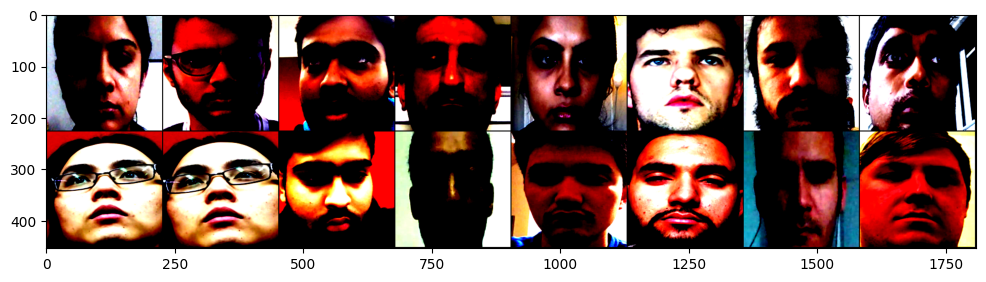

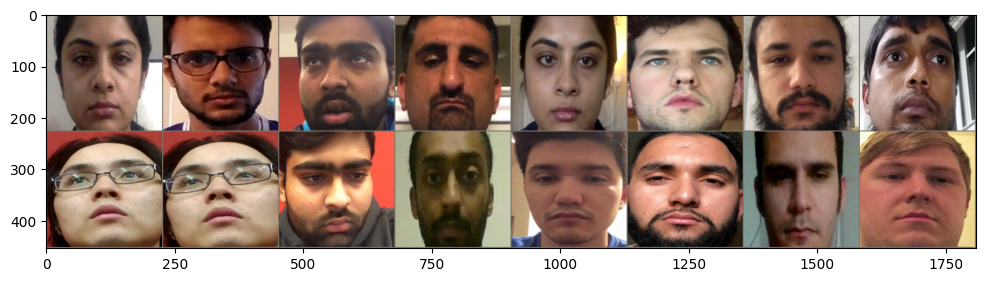

In [18]:
for images, labels in datamodule.val_dataloader():
    break
im=make_grid(images,nrow=8)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [19]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.val_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

                                                                    precision    recall  f1-score   support

    C:\Users\Aalind\Desktop\Driver Drowsiness Dataset (DDD)\Drowsy     0.9997    1.0000    0.9999      3637
C:\Users\Aalind\Desktop\Driver Drowsiness Dataset (DDD)\Non Drowsy     1.0000    0.9997    0.9998      3050

                                                          accuracy                         0.9999      6687
                                                         macro avg     0.9999    0.9998    0.9998      6687
                                                      weighted avg     0.9999    0.9999    0.9999      6687



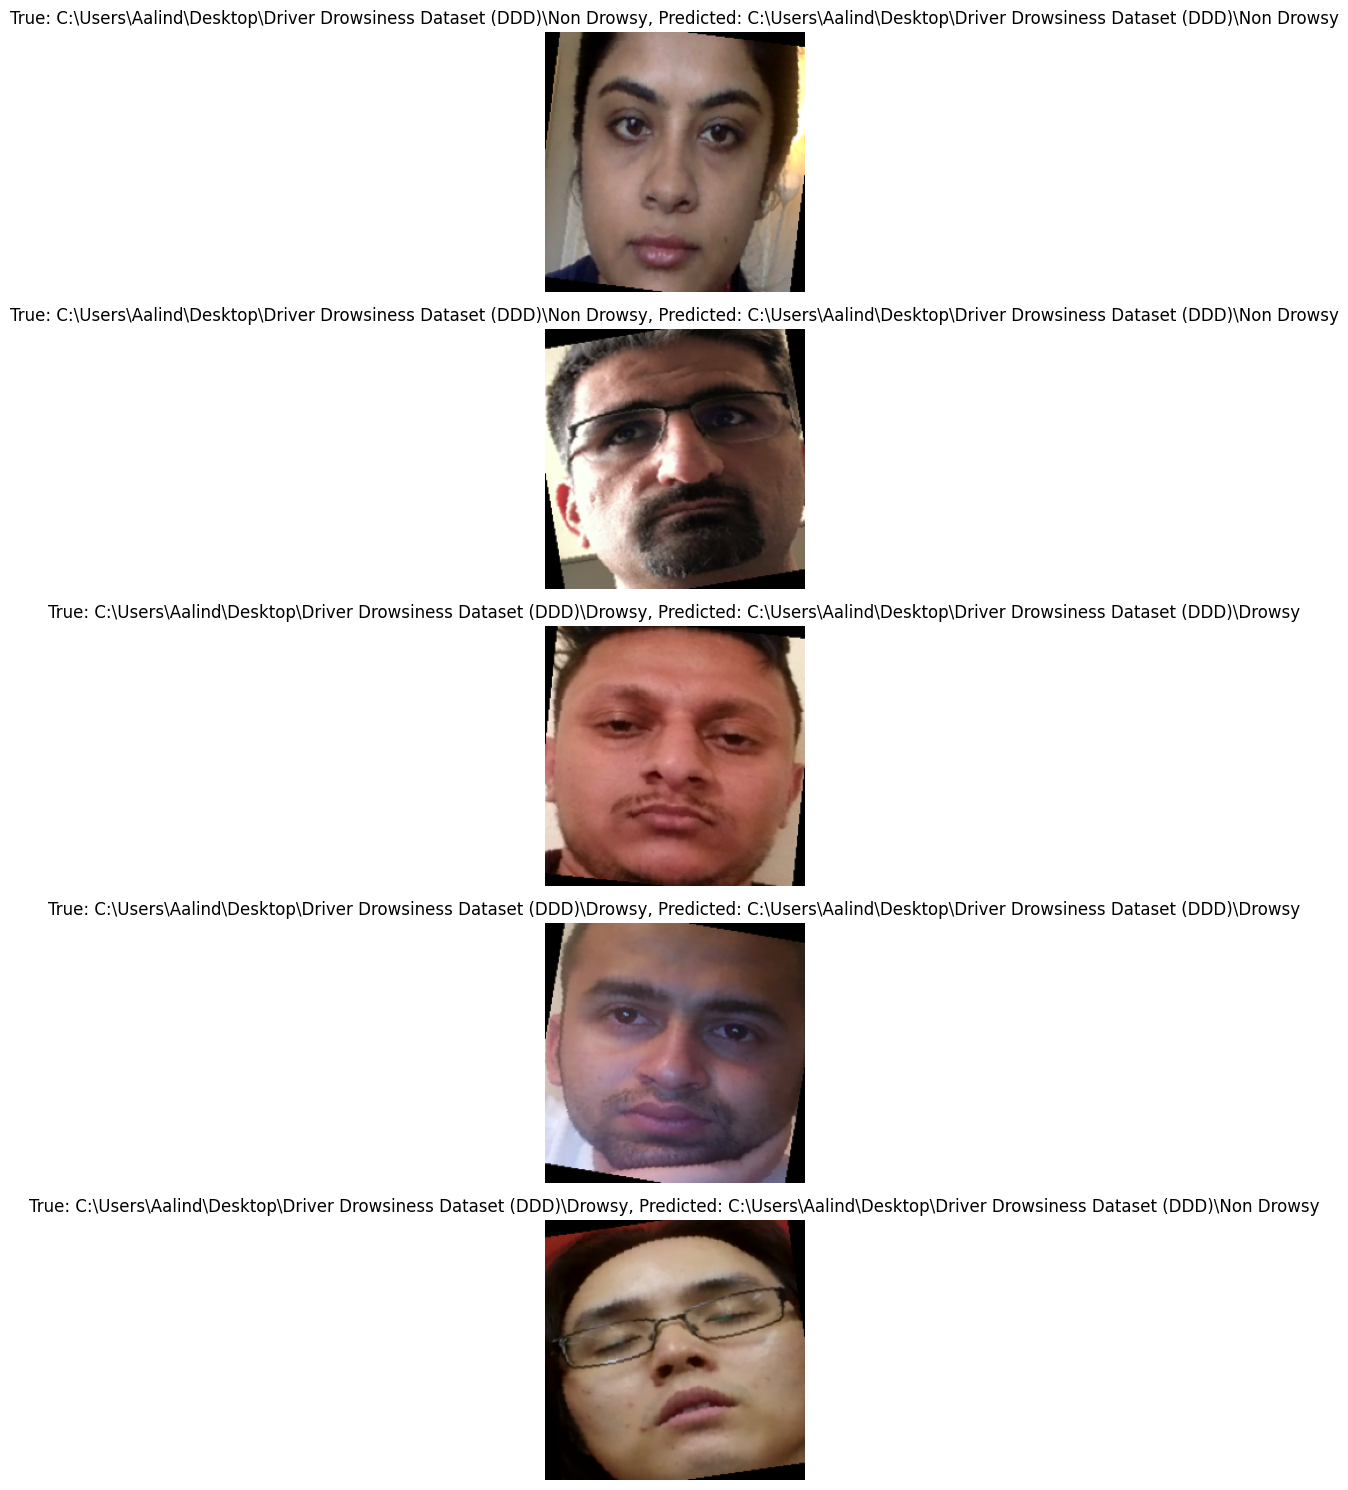

In [20]:

# Function to predict and display random images from the dataset
def test_random_images(dataset, model, class_names, num_images=5):
    model.eval()  # Set the model to evaluation mode
    random_indices = random.sample(range(len(dataset)), num_images)  # Select random indices
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    plt.figure(figsize=(15, num_images * 3))

    for i, idx in enumerate(random_indices):
        # Load image and label
        img, true_label = dataset[idx]
        img_unsqueezed = img.unsqueeze(0)  # Add batch dimension

        # Move to device (CPU in this case)
        img_unsqueezed = img_unsqueezed.to(device)
        true_label = true_label

        # Prediction
        with torch.no_grad():
            output = model(img_unsqueezed)
            pred_label = output.argmax(dim=1).item()

        # Denormalize for visualization
        img = inv_normalize(img)
        img = img.permute(1, 2, 0).numpy()  # Rearrange dimensions to HWC
        img = np.clip(img, 0, 1)  # Clip to valid range for display

        # Display image
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_label]}, Predicted: {class_names[pred_label]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use the dataset and model to test random images
test_random_images(CustomDataset(path_label, transform=transform), model, class_names, num_images=5)
